## Part IV.16: Experiments with Transformer Model Architecture

In this section, experiments and tuning exercises will be conducted using Transformer foundational model architecture.  This will include the following:

1.  Experiments with different depths of Transformer model architectures (number of encoder layers, etc.)
2.  Hyperparameter tuning/optimization

In [1]:
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, ConfusionMatrixDisplay, confusion_matrix

### Load Prepared Datasets

In [2]:
LOAD_FROM_GDRIVE = True

In [3]:
if(LOAD_FROM_GDRIVE):
    # mount google drive to load data
    from google.colab import drive
    drive.mount('/content/drive')

    dataset_root = '/content/drive/MyDrive/Datasets/sepsis/prepared'

    X_train = np.load(os.path.join(dataset_root, 'X_train.npy'))
    y_train = np.load(os.path.join(dataset_root, 'y_train.npy'))

    X_test = np.load(os.path.join(dataset_root, 'X_test.npy'))
    y_test = np.load(os.path.join(dataset_root, 'y_test.npy'))

    X_val =  np.load(os.path.join(dataset_root, 'X_val.npy'))
    y_val = np.load(os.path.join(dataset_root, 'y_val.npy'))

else:
    # load from datalake (S3)
    !aws s3 cp $s3_datalake_path_prepared $local_data_path_csv --recursive --exclude "*" --include "*.npy"

    X_train = np.load(os.path.join(local_data_path_csv, 'X_train.npy'))
    y_train = np.load(os.path.join(local_data_path_csv, 'y_train.npy'))

    X_test = np.load(os.path.join(local_data_path_csv, 'X_test.npy'))
    y_test = np.load(os.path.join(local_data_path_csv, 'y_test.npy'))

    X_val =  np.load(os.path.join(local_data_path_csv, 'X_val.npy'))
    y_val = np.load(os.path.join(local_data_path_csv, 'y_val.npy'))

Mounted at /content/drive


In [4]:
# inspect the loaded data
print(f"Train data shape: X: {X_train.shape}, y: {y_train.shape}")
print(f"Test data shape: X: {X_test.shape}, y: {y_test.shape}")
print(f"Validation data shape: X: {X_val.shape}, y: {y_val.shape}")

Train data shape: X: (3105, 48, 51), y: (3105,)
Test data shape: X: (388, 48, 51), y: (388,)
Validation data shape: X: (389, 48, 51), y: (389,)


In [5]:
# refactor targets to work for modeling
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [16]:
# global default training parameters
NUM_EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

# calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.reshape(-1,))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6933899062081287, 1: 1.7927251732101617}

### Helper Functions for Training Experiements

In [19]:
# define function to generate an encoder unit (ref: https://keras.io/examples/timeseries/timeseries_classification_transformer/)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def transformer_encoder_lff(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Dense(256, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# define function to build model with configurable settings (ref: https://keras.io/examples/timeseries/timeseries_classification_transformer/)
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    lff=False
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        if(lff):
            x = transformer_encoder_lff(x, head_size, num_heads, ff_dim, dropout)
        else:
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

# compile and train model
def compile_and_train_adam(model, checkpoint_callback):
  # Compile the model
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
  )
  # Train the model
  history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, class_weight=class_weights, callbacks=[checkpoint_callback])
  return history

# plot loss curves
def plot_loss(history, title, ignore_first=False):
  start_idx = 0
  if(ignore_first):
    start_idx = 1

  plt.plot(history.history['loss'][start_idx:])
  plt.plot(history.history['val_loss'][start_idx:])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Tain', 'Val'])
  plt.show()

# run forward pass and plot confusion matrix
def predict_and_plot_confusion(model, title):
  y_pred = model.predict(X_val)
  cm = confusion_matrix(y_val, np.round(y_pred).tolist())
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();
  plt.title(title)

def run_experiment(model, title, ignore_first=False):
  # train the model
  callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)]
  model_history = compile_and_train_adam(model, callbacks)

  #plot loss
  plot_loss(model_history, title + ' - Train/Val Loss', True)

  # confusion matrix
  predict_and_plot_confusion(model, "Confusion Matrix - Transformer head 512, 8 Blocks")

  # forward pass
  results = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
  print(f"Loss: {results[0]}")
  print(f"Binary Accuracy: {results[1]}")
  print(f"Precision: {results[2]}")
  print(f"Recall: {results[3]}")
  print(f"F1 Score: {results[4]}")

### Baseline Experiement

In [16]:
# define baseline model
input_shape = X_train.shape[1:]
baseline_xformer = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

# train the model
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)]
baseline_history = compile_and_train_adam(baseline_xformer, callbacks)

Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 419ms/step - binary_accuracy: 0.6374 - f1_score: 0.4326 - loss: 0.7761 - precision_3: 0.3973 - recall_3: 0.6154 - val_binary_accuracy: 0.7506 - val_f1_score: 0.4090 - val_loss: 0.5359 - val_precision_3: 0.5105 - val_recall_3: 0.7300
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - binary_accuracy: 0.7842 - f1_score: 0.4375 - loss: 0.4989 - precision_3: 0.5904 - recall_3: 0.7483 - val_binary_accuracy: 0.7404 - val_f1_score: 0.4090 - val_loss: 0.5614 - val_precision_3: 0.4969 - val_recall_3: 0.7900
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - binary_accuracy: 0.8091 - f1_score: 0.4481 - loss: 0.4667 - precision_3: 0.6395 - recall_3: 0.7796 - val_binary_accuracy: 0.8226 - val_f1_score: 0.4090 - val_loss: 0.4514 - val_precision_3: 0.6202 - val_recall_3: 0.8000
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - binary_accuracy: 0.8492 - f1_score: 0.4355 - loss: 0.4105 - precision_3: 0.6926 - recall_3: 0.8233 - val_binary_accuracy: 

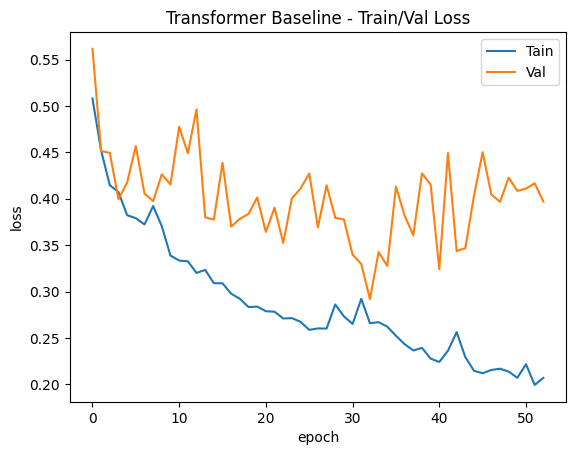

In [17]:
#plot loss
plot_loss(baseline_history, 'Transformer Baseline - Train/Val Loss', True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step


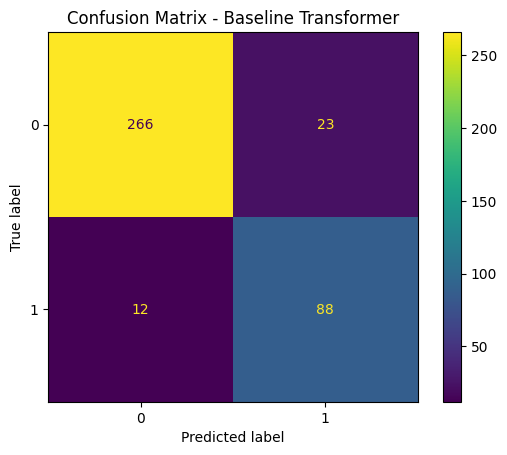

In [18]:
predict_and_plot_confusion(baseline_xformer, "Confusion Matrix - Baseline Transformer")

In [19]:
results = baseline_xformer.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
print(f"Loss: {results[0]}")
print(f"Binary Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Recall: {results[3]}")
print(f"F1 Score: {results[4]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.9124 - f1_score: 0.3978 - loss: 0.2969 - precision_3: 0.7914 - recall_3: 0.8792
Loss: 0.2919168174266815
Binary Accuracy: 0.9100257158279419
Precision: 0.792792797088623
Recall: 0.8799999952316284
F1 Score: 0.40899792313575745


In [20]:
# save baseline model
baseline_xformer.save('/content/drive/MyDrive/Datasets/sepsis/models/xformer_baseline.keras')

### Transformer Experiment 1: Increase Number of Encoders

In [24]:
# define baseline model
input_shape = X_train.shape[1:]
xformer_e1 = build_model(
    input_shape,
    head_size=512,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.3,
)

# train the model
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)]
xformer_e1_history = compile_and_train_adam(xformer_e1, callbacks)

Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 855ms/step - binary_accuracy: 0.6343 - f1_score: 0.4409 - loss: 0.8967 - precision_5: 0.3981 - recall_5: 0.5908 - val_binary_accuracy: 0.7686 - val_f1_score: 0.4090 - val_loss: 0.5434 - val_precision_5: 0.5397 - val_recall_5: 0.6800
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - binary_accuracy: 0.7503 - f1_score: 0.4412 - loss: 0.5291 - precision_5: 0.5430 - recall_5: 0.7758 - val_binary_accuracy: 0.8278 - val_f1_score: 0.4090 - val_loss: 0.4517 - val_precision_5: 0.6701 - val_recall_5: 0.6500
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - binary_accuracy: 0.8131 - f1_score: 0.4431 - loss: 0.4684 - precision_5: 0.6359 - recall_5: 0.8010 - val_binary_accuracy: 0.8612 - val_f1_score: 0.4090 - val_loss: 0.4011 - val_precision_5: 0.8108 - val_recall_5: 0.6000
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - binary_accuracy: 0.8179 - f1_score: 0.4387 - loss: 0.4658 - precision_5: 0.6539 - recall_5: 0.7501 - val_binary_accuracy: 

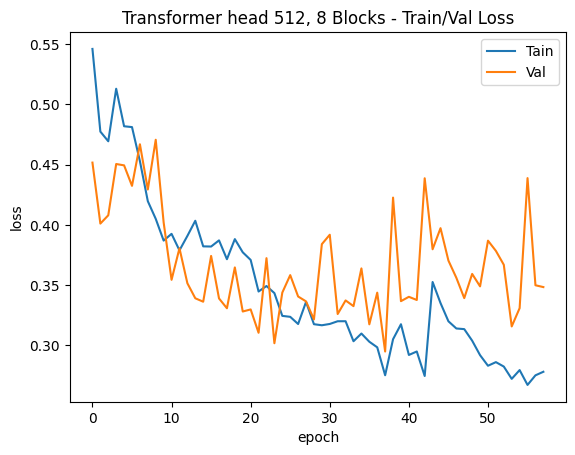

In [26]:
#plot loss
plot_loss(xformer_e1_history, 'Transformer head 512, 8 Blocks - Train/Val Loss', True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step


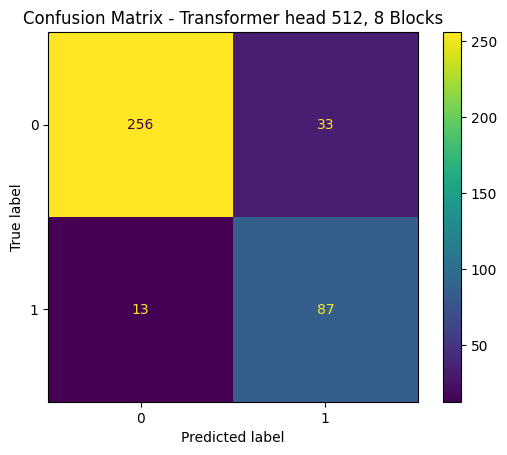

In [27]:
predict_and_plot_confusion(xformer_e1, "Confusion Matrix - Transformer head 512, 8 Blocks")

In [ ]:
results = xformer_e1.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
print(f"Loss: {results[0]}")
print(f"Binary Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Recall: {results[3]}")
print(f"F1 Score: {results[4]}")

In [ ]:
# save baseline model
xformer_e1.save('/content/drive/MyDrive/Datasets/sepsis/models/xformer_e1.keras')

### Transformer Experiment 2: LSTM as Feed-Forward Units

Epoch 1/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - binary_accuracy: 0.6601 - f1_score: 0.4434 - loss: 0.6989 - precision_3: 0.4374 - recall_3: 0.6447 - val_binary_accuracy: 0.8098 - val_f1_score: 0.4090 - val_loss: 0.4503 - val_precision_3: 0.5903 - val_recall_3: 0.8500
Epoch 2/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - binary_accuracy: 0.7965 - f1_score: 0.4489 - loss: 0.4698 - precision_3: 0.6177 - recall_3: 0.7892 - val_binary_accuracy: 0.8612 - val_f1_score: 0.4090 - val_loss: 0.4149 - val_precision_3: 0.6983 - val_recall_3: 0.8100
Epoch 3/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - binary_accuracy: 0.8616 - f1_score: 0.4450 - loss: 0.3896 - precision_3: 0.7358 - recall_3: 0.8087 - val_binary_accuracy: 0.8843 - val_f1_score: 0.4090 - val_loss: 0.3452 - val_precision_3: 0.7619 - val_recall_3: 0.8000
Epoch 4/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - binary_accuracy: 0.8758 - f1_score: 0.4241 - loss: 0.3421 - precision_3: 0.7343 - recall_3: 0.8437 - val_binary_accuracy: 0

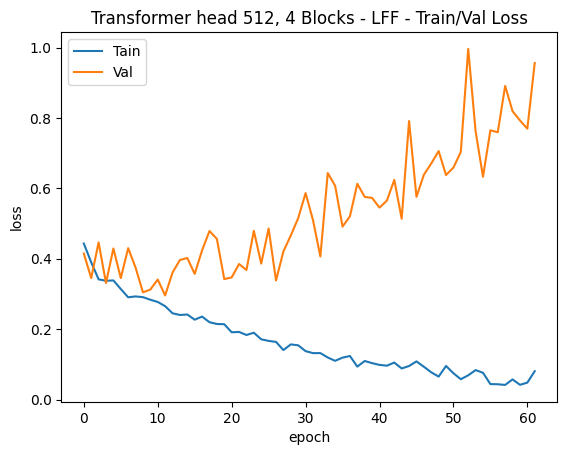

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - binary_accuracy: 0.9040 - f1_score: 0.3978 - loss: 0.2670 - precision_3: 0.7839 - recall_3: 0.8485
Loss: 0.29586365818977356
Binary Accuracy: 0.8946015238761902
Precision: 0.7657657861709595
Recall: 0.8500000238418579
F1 Score: 0.40899792313575745


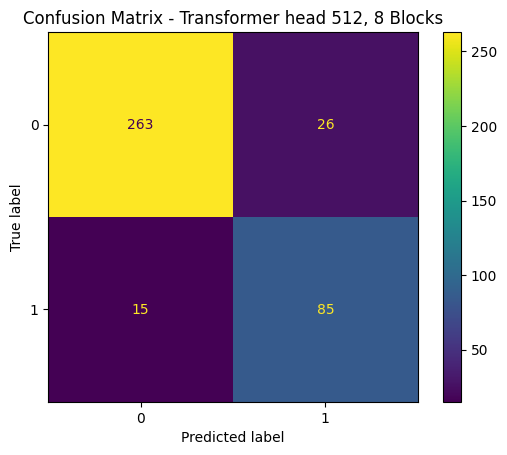

In [20]:
# define baseline model
input_shape = X_train.shape[1:]
xformer_lff1 = build_model(
    input_shape,
    head_size=256,
    num_heads=8,
    ff_dim=8,
    num_transformer_blocks=8,
    mlp_units=[512],
    mlp_dropout=0.2,
    dropout=0.3,
    lff=True
)

# run experiment
run_experiment(xformer_lff1, "Transformer head 512, 4 Blocks - LFF")